# Preferential Bayesian Optimization: Predictive Entropy Search
This notebook demonstrates the use of the Predictive Entropy Search (PES) acquisition function on ordinal (preference) data.

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
gpu_to_use = 0

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[gpu_to_use], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [3]:
objective = PBO.objectives.forrester
objective_low = 0.
objective_high = 1.
objective_name = "Forrester"
acquisition_name = "PES"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name + "FullGP"

In [4]:
num_runs = 20
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 1
objective_dim = input_dims
num_maximizers = 20
num_maximizers_init = 50
num_fourier_features = 100
num_init_prefs = 3

# CHANGE 1: reduce the value of delta to avoid numerical error
# as k(x,x') = sigma^2 * exp( -[(x-x')/l]^2 )
# which could be very small if l is too small
# so we define l relatively by the range of input (objective_high - objective_low)
#   It is ok for the total number of observations > the total number of possible inputs
# because there is a noise in the observation, it might require repeated observations 
# at the same input pair to improve the confidence 
num_discrete_per_dim = 60
delta = (objective_high - objective_low) / num_discrete_per_dim

In [5]:
lengthscale = 0.05
lengthscale_prior_alpha = tf.constant(2, dtype=tf.float64)
lengthscale_prior_beta = tf.constant(4, dtype=tf.float64)

In [6]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/qphong/Data/Workspace/preferencebo/PBO/notebooks/PES/results/PBO_PES_ForresterFullGP/  already exists


Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

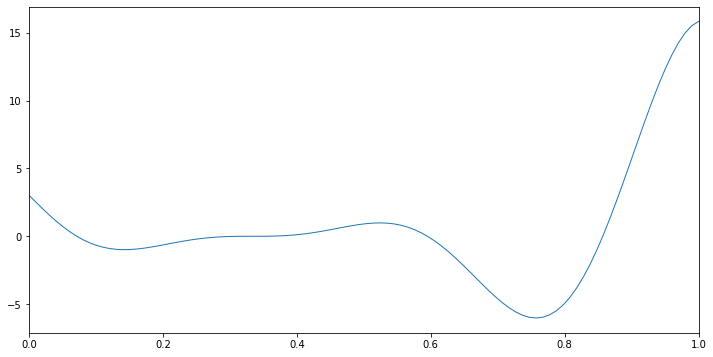

In [7]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, objective(xx), 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [8]:
def plot_gp(model, X, y, title, cmap="Spectral"):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

    plt.savefig(fname=results_dir + title + ".png")

In [9]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [10]:
def train_and_visualize(X, y, title, lengthscale_init=None, signal_variance_init=None):
    lengthscale_prior = tfp.distributions.Gamma(concentration=lengthscale_prior_alpha,
                                               rate=lengthscale_prior_beta)
    
    # Train model with data 
    result = PBO.models.learning_fullgp.train_model_fullcov(
                        X, y, 
                        obj_low=objective_low,
                        obj_high=objective_high,
                        lengthscale_init=lengthscale_init,
                        signal_variance_init=signal_variance_init,
                        indifference_threshold=0.,
                        n_sample=1000,
                        deterministic=True, # only sample f values once, not re-sampling
                        num_steps=3000)
    
    q_mu = result['q_mu']
    q_sqrt = result['q_sqrt']
    u = result['u']
    inputs = result['inputs']
    k = result['kernel']
        
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, u_mean, title)
    
    return model, inputs, u_mean, inducing_vars

In [11]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the target (in this case, the global minimum of the Forrester function), the better.

In [12]:
def best_guess(model):
    """
    Returns a GP model's best guess of the global maximum of f.
    """
    xx = PBO.models.learning_fullgp.get_all_discrete_inputs(objective_low, objective_high, objective_dim, delta)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [13]:
num_data_at_end = int(num_init_prefs + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [14]:
np.random.seed(0)

init_vals = np.zeros([num_runs, num_init_prefs, num_choices, input_dims])

for run in range(num_runs):
    for i in range(num_init_prefs):
        init_vals[run,i] = PBO.models.learning_fullgp.get_random_inputs(
                                objective_low, 
                                objective_high, 
                                objective_dim, 
                                delta,
                                size=num_choices,
                                with_replacement=False,
                                exclude_inputs=None)

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.


Beginning run 0
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
Indifference_threshold is fixed at 0.0
Initialize lengthscale at [0.5]
       signal variance at 1.0
   Initial negative ELBO: 49584279.8479599
Negative ELBO at step 0: 49046694.2926284 in 0.4426s
Negative ELBO at step 500: 186061.46263686175 in 17.4767s
Negative ELBO at step 1000: 11.226026144876313 in 17.8846s
Negative ELBO at step 1500: 4.680047887625013 in 17.8138s
Negative ELBO at step 2000: 3.625913451269489 in 17.3647s
Negative ELBO at step 2500: 3.3731878651681075 in 17.0246s
Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: -0.03795895277749643
Loss at step 459: -0.5052145699107369
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.60595073]
 [0.57709592]
 [0.82139524]
 [0.32457763]
 [0.28381055]
 [0.59313008]
 [0.35129017]
 [0.70976344]
 [0.33567339]
 [0.67512181]
 [1.        ]
 [0.31862293]
 [0.70133268]


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.9114148939881481
SVGP.kernel.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.09862188]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(6, 1)",float64,[[0.70833333...
SVGP.q_mu,Parameter,,,False,"(6, 1)",float64,[[0.37600125...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 6, 6)",float64,"[[[0.73399818, 0., 0...."


Best_guess f([0.79166667]) = -5.335648712126089
Beginning evaluation 1
Evaluation 1: Sampling maximizers
Loss at step 0: -0.018731924568769934
Loss at step 500: -0.6525058453721736
Loss at step 1000: -0.6525066551249294
Loss at step 1500: -0.6525068482410646
Loss at step 2000: -0.6525069169398883
Loss at step 2500: -0.6525069492519809
Loss at step 2691: -0.6525070224372617
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.7684641 ]
 [0.28975211]
 [0.87196269]
 [0.00687319]
 [0.7560249 ]
 [0.12657435]
 [0.68964752]
 [0.91490232]
 [0.73071037]
 [1.        ]
 [0.77256989]
 [0.77176737]
 [0.33156973]
 [0.8750175 ]
 [0.69448334]
 [0.82399711]
 [0.75125073]
 [1.        ]
 [0.8164809 ]
 [0.7307132 ]], shape=(20, 1), dtype=float64)
Evaluation 1: Calculating I
Evaluation 1: Next query is tf.Tensor(
[[0.80833333]
 [0.14166667]], shape=(2, 1), dtype=float64) with I value of 0.07083211335835626
Evaluation 1: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.8255552792451581
SVGP.kernel.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.09779035]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(7, 1)",float64,[[0.70833333...
SVGP.q_mu,Parameter,,,False,"(7, 1)",float64,[[0.49199871...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 7, 7)",float64,"[[[7.21998642e-01, 0.00000000e+00, 0.00000000e+00..."


Best_guess f([0.79166667]) = -5.335648712126089
Beginning evaluation 2
Evaluation 2: Sampling maximizers
Loss at step 0: 0.017048405140610647
Loss at step 500: -0.7475940516572052
Loss at step 1000: -0.7475952856369015
Loss at step 1500: -0.747595642916402
Loss at step 2000: -0.7475957765282283
Loss at step 2087: -0.7475957148723869
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.76741423]
 [0.77957467]
 [0.6918585 ]
 [0.86865329]
 [1.        ]
 [0.28978976]
 [0.91723412]
 [0.2560998 ]
 [0.73146439]
 [0.17370862]
 [0.28363813]
 [0.55447508]
 [0.74717061]
 [0.35726557]
 [0.9614876 ]
 [0.70834193]
 [0.88208241]
 [0.06903476]
 [0.74430057]
 [0.56063723]], shape=(20, 1), dtype=float64)
Evaluation 2: Calculating I
Evaluation 2: Next query is tf.Tensor(
[[0.70833333]
 [0.90833333]], shape=(2, 1), dtype=float64) with I value of 0.07083194285104806
Evaluation 2: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, '

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.3273890556155084
SVGP.kernel.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.08331616]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(8, 1)",float64,[[0.70833333...
SVGP.q_mu,Parameter,,,False,"(8, 1)",float64,[[0.89000067...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 8, 8)",float64,"[[[0.93398932, 0., 0...."


Best_guess f([0.75833333]) = -6.02010997183608
Beginning evaluation 3
Evaluation 3: Sampling maximizers
Loss at step 0: 0.09802061148270172
Loss at step 343: -0.6907056147431324
test.shape =  (20, 50, 1)
tf.Tensor(
[[1.        ]
 [0.12884723]
 [0.85588611]
 [0.71701218]
 [0.74890619]
 [0.79287757]
 [0.72722252]
 [0.84741047]
 [0.74583213]
 [0.7480308 ]
 [0.8449399 ]
 [0.73853107]
 [0.99332965]
 [0.75453869]
 [0.13397329]
 [0.73709641]
 [1.        ]
 [0.75038637]
 [0.25299592]
 [0.17096147]], shape=(20, 1), dtype=float64)
Evaluation 3: Calculating I
Evaluation 3: Next query is tf.Tensor(
[[0.80833333]
 [0.24166667]], shape=(2, 1), dtype=float64) with I value of 0.07102168291128554
Evaluation 3: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
Indifference_threshold is fixed at 0.0
Initialize lengthscale at [0.32]
       signal variance at 1.0
   Initial negative ELBO: 3116891120.

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.4597385412265016
SVGP.kernel.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.08807864]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(9, 1)",float64,[[0.70833333...
SVGP.q_mu,Parameter,,,False,"(9, 1)",float64,[[1.08600561...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 9, 9)",float64,"[[[0.92200057, 0., 0...."


Best_guess f([0.75833333]) = -6.02010997183608
Beginning evaluation 4
Evaluation 4: Sampling maximizers
Loss at step 0: -0.0035477099545650577
Loss at step 376: -0.8984946382953398
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.99047925]
 [0.18032968]
 [0.74868004]
 [0.82627842]
 [0.87190113]
 [0.81291219]
 [0.76444513]
 [0.26967547]
 [1.        ]
 [0.79632046]
 [0.68158906]
 [0.72356107]
 [0.75672314]
 [0.88221361]
 [0.78565779]
 [0.76443989]
 [0.81209502]
 [1.        ]
 [1.        ]
 [0.79796453]], shape=(20, 1), dtype=float64)
Evaluation 4: Calculating I
Evaluation 4: Next query is tf.Tensor(
[[0.70833333]
 [0.875     ]], shape=(2, 1), dtype=float64) with I value of 0.08133686627103076
Evaluation 4: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
Indifference_threshold is fixed at 0.0
Initialize lengthscale at [0.256]
       signal variance at 1.0
   Initial negative ELBO: 9519755

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.189989218638351
SVGP.kernel.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.07636248]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(10, 1)",float64,[[0.70833333...
SVGP.q_mu,Parameter,,,False,"(10, 1)",float64,[[1.70002039...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 10, 10)",float64,"[[[1.10004659e+00, 0.00000000e+00, 0.00000000e+00..."


Best_guess f([0.74166667]) = -5.897171807277554
Beginning evaluation 5
Evaluation 5: Sampling maximizers
Loss at step 0: -0.2632778568345707
Loss at step 500: -1.795140394179025
Loss at step 1000: -1.79514603979726
Loss at step 1500: -1.7951489104548701
Loss at step 2000: -1.7951506060370253
Loss at step 2500: -1.7951516878568314
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.04816295]
 [1.        ]
 [0.75021333]
 [0.27232461]
 [0.33823764]
 [1.        ]
 [0.78910262]
 [0.5268394 ]
 [0.72991354]
 [0.73894445]
 [0.76268075]
 [0.82803044]
 [0.60819205]
 [0.07895144]
 [0.83215389]
 [0.7783325 ]
 [0.732759  ]
 [0.71953185]
 [0.71956925]
 [0.7873096 ]], shape=(20, 1), dtype=float64)
Evaluation 5: Calculating I
Evaluation 5: Next query is tf.Tensor(
[[0.80833333]
 [0.69166667]], shape=(2, 1), dtype=float64) with I value of 0.07880624594087282
Evaluation 5: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'cen

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.4648328138125617
SVGP.kernel.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.06199396]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(11, 1)",float64,[[0.70833333...
SVGP.q_mu,Parameter,,,False,"(11, 1)",float64,[[0.45200101...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 11, 11)",float64,"[[[5.29999914e-01, 0.00000000e+00, 0.00000000e+00..."


Best_guess f([0.74166667]) = -5.897171807277554
Beginning evaluation 6
Evaluation 6: Sampling maximizers
Loss at step 0: 0.06555620130112397
Loss at step 500: -0.6287917422738311
Loss at step 1000: -0.628795615819108
Loss at step 1500: -0.6287974603680245
Loss at step 2000: -0.6287984883405637
Loss at step 2500: -0.6287991101934504
test.shape =  (20, 50, 1)
tf.Tensor(
[[1.        ]
 [0.99223823]
 [1.        ]
 [0.77030865]
 [0.36297775]
 [0.65116478]
 [0.98522194]
 [0.6081068 ]
 [0.1480574 ]
 [0.44928612]
 [0.68991968]
 [0.73493457]
 [1.        ]
 [0.24899269]
 [0.81495108]
 [0.32472982]
 [0.40382031]
 [0.74288874]
 [1.        ]
 [0.75376676]], shape=(20, 1), dtype=float64)
Evaluation 6: Calculating I
Evaluation 6: Next query is tf.Tensor(
[[0.64166667]
 [0.775     ]], shape=(2, 1), dtype=float64) with I value of 0.03717452356438167
Evaluation 6: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'c

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.7716710515404078
SVGP.kernel.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.05723598]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(12, 1)",float64,[[0.70833333...
SVGP.q_mu,Parameter,,,False,"(12, 1)",float64,[[0.65800098...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 12, 12)",float64,"[[[6.47999805e-01, 0.00000000e+00, 0.00000000e+00..."


Best_guess f([0.74166667]) = -5.897171807277554
Beginning evaluation 7
Evaluation 7: Sampling maximizers
Loss at step 0: 0.799900291333658
Loss at step 240: -1.7655615701914213
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.75066814]
 [0.18877342]
 [1.        ]
 [0.18768127]
 [1.        ]
 [0.31716861]
 [0.47607338]
 [0.88562947]
 [0.48276576]
 [1.        ]
 [0.72264183]
 [0.78422348]
 [0.49489955]
 [0.69458931]
 [1.        ]
 [0.13566428]
 [0.97674875]
 [0.33897349]
 [1.        ]
 [0.47123396]], shape=(20, 1), dtype=float64)
Evaluation 7: Calculating I
Evaluation 7: Next query is tf.Tensor(
[[0.775     ]
 [0.34166667]], shape=(2, 1), dtype=float64) with I value of 0.04848485909380931
Evaluation 7: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
Indifference_threshold is fixed at 0.0
Initialize lengthscale at [0.131072]
       signal variance at 1.0
   Initial negative ELBO: 12911972

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.1651403920500605
SVGP.kernel.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.05712874]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(13, 1)",float64,[[0.70833333...
SVGP.q_mu,Parameter,,,False,"(13, 1)",float64,[[0.96601076...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 13, 13)",float64,"[[[0.71399995, 0., 0...."


Best_guess f([0.74166667]) = -5.897171807277554
Beginning evaluation 8
Evaluation 8: Sampling maximizers
Loss at step 0: 0.09093438003185202
Loss at step 500: -1.4017280790419107
Loss at step 1000: -1.4017366847480883
Loss at step 1500: -1.401741755638028
Loss at step 2000: -1.4017451258737321
Loss at step 2500: -1.4017475093486007
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.07405318]
 [1.        ]
 [0.04523636]
 [0.77621252]
 [0.12068006]
 [0.73907271]
 [0.78704733]
 [0.73391745]
 [1.        ]
 [0.76973019]
 [0.27412368]
 [0.47397168]
 [0.30376256]
 [0.21911198]
 [0.17803427]
 [0.75117221]
 [0.48261944]
 [0.06880282]
 [0.03039004]
 [0.06379911]], shape=(20, 1), dtype=float64)
Evaluation 8: Calculating I
Evaluation 8: Next query is tf.Tensor(
[[0.775     ]
 [0.04166667]], shape=(2, 1), dtype=float64) with I value of 0.06944180994741028
Evaluation 8: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'c

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.2054299154210737
SVGP.kernel.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.05927699]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(14, 1)",float64,[[0.70833333...
SVGP.q_mu,Parameter,,,False,"(14, 1)",float64,[[1.06600017...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 14, 14)",float64,"[[[6.87999858e-01, 0.00000000e+00, 0.00000000e+00..."


Best_guess f([0.74166667]) = -5.897171807277554
Beginning evaluation 9
Evaluation 9: Sampling maximizers
Loss at step 0: 0.039616314454257416
Loss at step 500: -1.5244020411426809
Loss at step 1000: -1.5244094325282027
Loss at step 1500: -1.5244136670098452
Loss at step 2000: -1.5244164124332007
Loss at step 2500: -1.5244183139200114
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.1910593 ]
 [0.47674728]
 [0.79391839]
 [0.36857931]
 [0.79708035]
 [1.        ]
 [0.        ]
 [0.49226818]
 [1.        ]
 [0.25546223]
 [0.        ]
 [0.85880672]
 [0.16553159]
 [0.45721893]
 [0.11022419]
 [0.65141053]
 [0.        ]
 [0.99101842]
 [1.        ]
 [0.7512511 ]], shape=(20, 1), dtype=float64)
Evaluation 9: Calculating I
Evaluation 9: Next query is tf.Tensor(
[[0.775]
 [0.975]], shape=(2, 1), dtype=float64) with I value of 0.049753073101195575
Evaluation 9: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'centered

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.1844961943043497
SVGP.kernel.lengthscale,Parameter,Softplus + Shift,,True,"(1,)",float64,[0.05881832]
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(15, 1)",float64,[[0.70833333...
SVGP.q_mu,Parameter,,,False,"(15, 1)",float64,[[1.10800164...
SVGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 15, 15)",float64,"[[[0.68199986, 0., 0...."


Best_guess f([0.75833333]) = -6.02010997183608
Beginning evaluation 10
Evaluation 10: Sampling maximizers
Loss at step 0: 0.16252403282679592
Loss at step 500: -2.384539843023419
Loss at step 1000: -2.384548113259925
Loss at step 1500: -2.384553353181167
Loss at step 2000: -2.3845571104873726
Loss at step 2500: -2.3845599928893693
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.19521554]
 [0.29110989]
 [0.        ]
 [0.08444498]
 [1.        ]
 [0.19100581]
 [0.        ]
 [0.28965909]
 [0.20459507]
 [0.76570597]
 [0.33731937]
 [0.19143253]
 [0.4746044 ]
 [1.        ]
 [0.19076119]
 [0.80071895]
 [0.18790747]
 [0.47996435]
 [0.79305094]
 [1.        ]], shape=(20, 1), dtype=float64)
Evaluation 10: Calculating I
Evaluation 10: Next query is tf.Tensor(
[[0.80833333]
 [0.00833333]], shape=(2, 1), dtype=float64) with I value of 0.03849508252866604
Evaluation 10: Training model
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 

KeyboardInterrupt: 

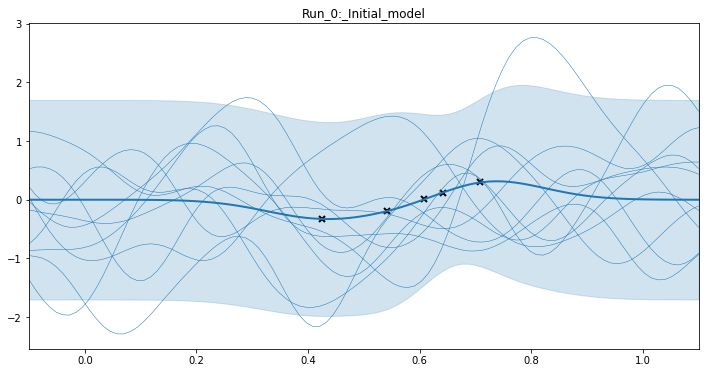

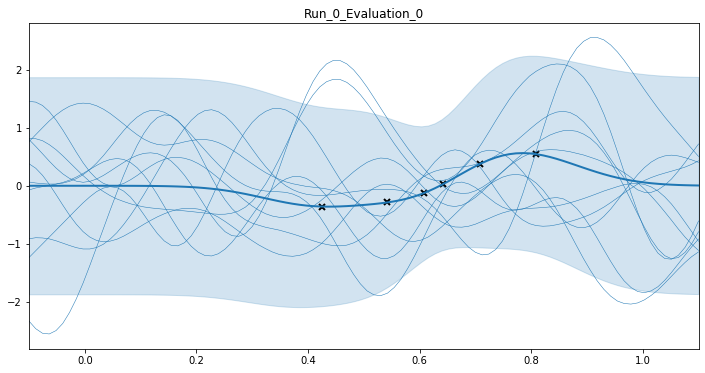

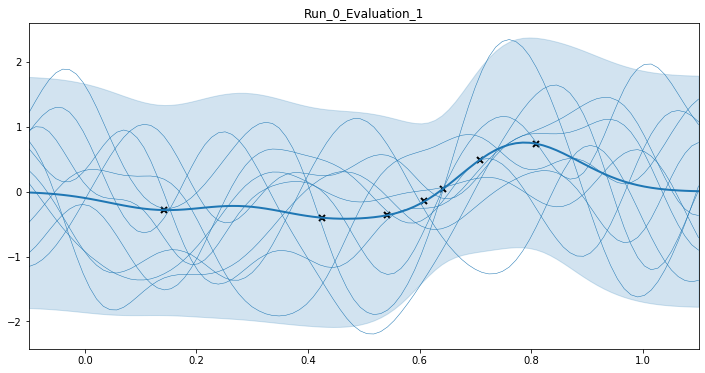

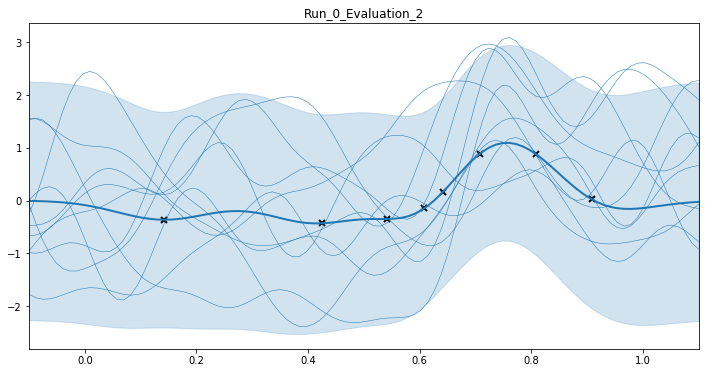

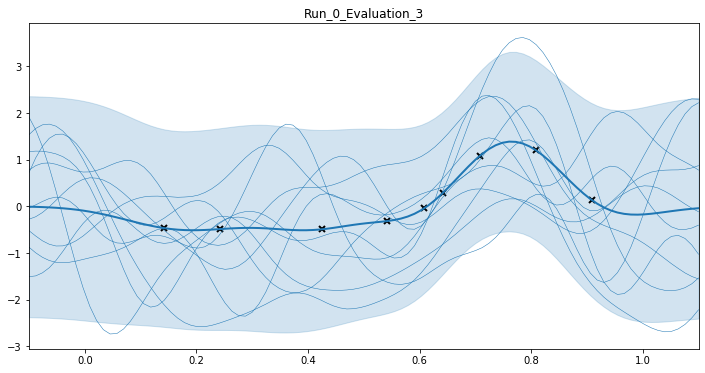

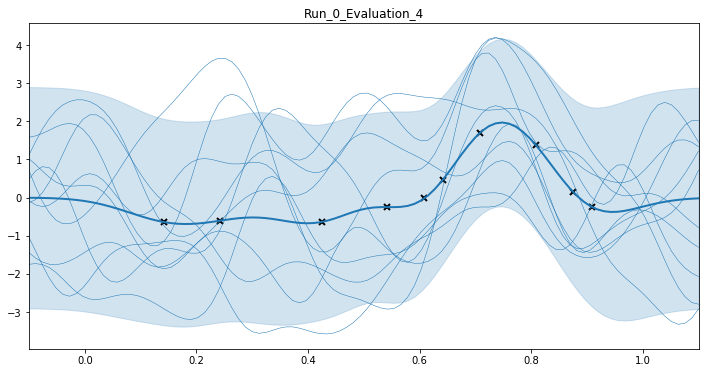

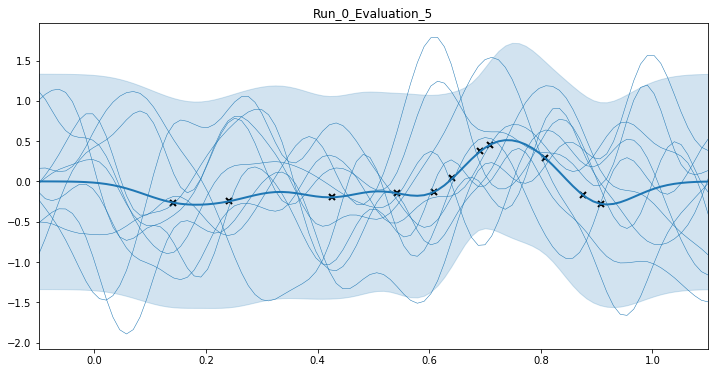

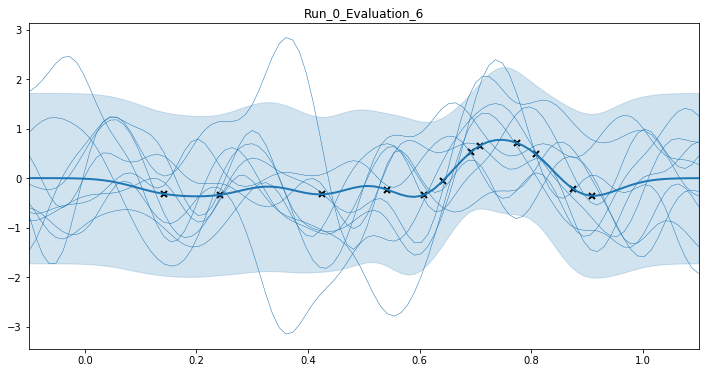

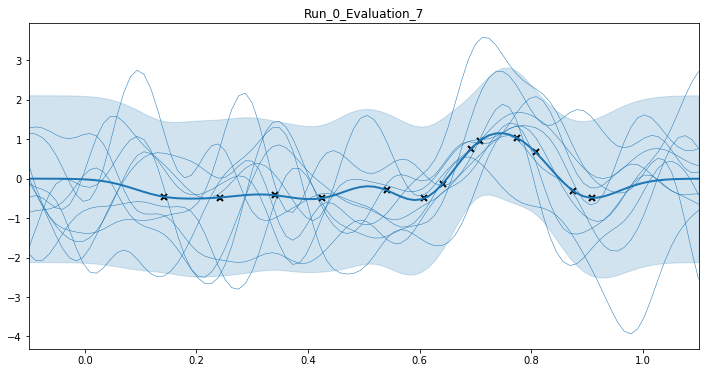

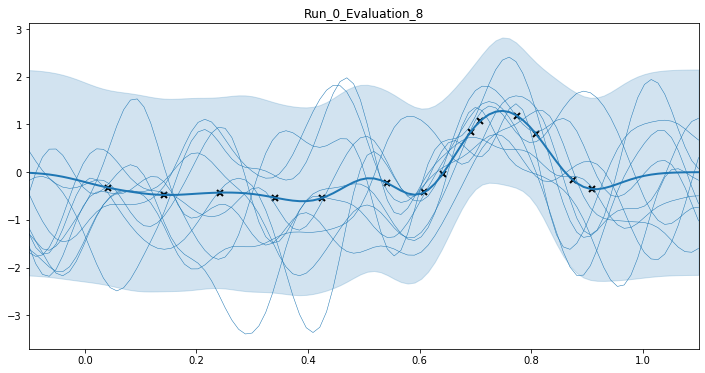

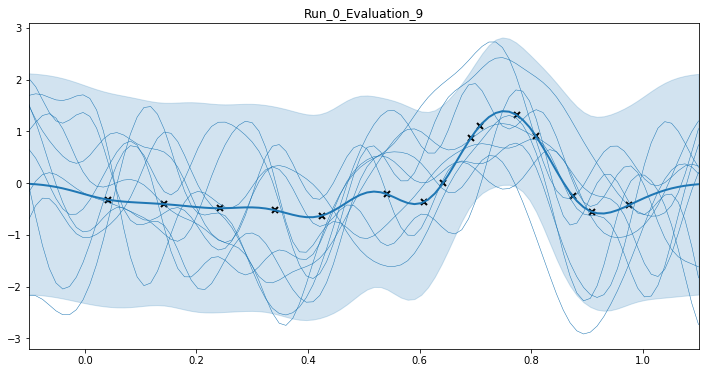

In [15]:
# CHANGE 2: remove the lengthscale_init and signal_variance_init
# as it makes the optimization stuck in local optima (a very small lengthscale)
# At each iteration, we optimize with the initial lengthscale = (objective_high - objective_low) / 2
# so that it can discover an optima with large lengthscale instead
for run in range(num_runs):
    print("")
    print("==================")
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                        "Run_{}:_Initial_model".format(run))
    
    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 

        # Sample possible next queries
        samples = PBO.models.learning_fullgp.sample_inputs(inputs.numpy(), 
                                                           num_samples, 
                                                           num_choices, 
                                                           objective_low, 
                                                           objective_high,
                                                           delta)

        # Sample maximizers
        print("Evaluation %s: Sampling maximizers" % (evaluation))
        maximizers = PBO.fourier_features.sample_maximizers(X=inducing_vars,
                                                            count=num_maximizers,
                                                            n_init=num_maximizers_init,
                                                            D=num_fourier_features,
                                                            model=model,
                                                            min_val=objective_low,
                                                            max_val=objective_high)
        print(maximizers)

        # Calculate PES value I for each possible next query
        print("Evaluation %s: Calculating I" % (evaluation))
        I_vals = PBO.acquisitions.pes.I_batch(samples, maximizers, model)

        # Select query that maximizes I
        next_idx = np.argmax(I_vals)
        next_query = samples[next_idx]
        print("Evaluation %s: Next query is %s with I value of %s" % (evaluation, next_query, I_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = np.concatenate([y, get_noisy_observation(np.expand_dims(next_query, axis=0), objective)], axis=0)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y,  
                                                                   "Run_{}_Evaluation_{}".format(run, evaluation))
        print_summary(model)

        best_guess_results[run, evaluation, :] = best_guess(model)

        print("Best_guess f({}) = {}".format(
                best_guess_results[run, evaluation, :], 
                objective(best_guess_results[run, evaluation, :])))
        
                
        # Save model
        pickle.dump((X, y, inputs, 
                     model.kernel.variance, 
                     model.kernel.lengthscale, 
                     model.likelihood.variance, 
                     inducing_vars, 
                     model.q_mu, 
                     model.q_sqrt, 
                     maximizers), 
                    open(results_dir + "Model_Run_{}_Evaluation_{}.p".format(run, evaluation), "wb"))

    X_results[run] = X
    y_results[run] = y

In [ ]:
model.kernel

In [ ]:
pickle.dump((X_results, y_results, best_guess_results), open(results_dir + "Xybestguess.p", "wb"))

In [ ]:
def dist(x, y):
    """
    x and y have shape (..., input_dims)
    """
    return np.sqrt(np.sum((x - y) * (x - y), axis=-1))

In [ ]:
# CHANGE 3: use learning_fullgp.get_all_discrete_inputs instead of uniform_grid
# so that global_min is in the set of queries by BO (since BO queries must be in learning_fullgp.get_all_discrete_inputs)
# TODO: we need to report the [objective(best_guess) - objective(global_min)] as another performance measure
#    because the objective function might have multiple optima
#    the distance between these optima inputs might be far away,
#    but their objective function values are close.

#xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
xx = PBO.models.learning_fullgp.get_all_discrete_inputs(objective_low, objective_high, objective_dim, delta)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = dist(best_guess_results[i], global_min)
    
    x_axis = list(range(num_combs+1, num_combs+1+num_evals))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess distance', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()